In [1]:
import cv2
import os
import time
import numpy as np
import os, random
import matplotlib.pylab as plt
import scipy.cluster.hierarchy as hcluster
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
import keras.utils.vis_utils as vutil
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from keras.optimizers import SGD
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Input, Dense, Lambda, add
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import conv_utils
from keras.engine.topology import Layer
import scipy.stats
from keras.engine import InputSpec
from skimage.morphology import convex_hull_image
import numpy as np
from keras.layers import LSTM
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys

#%matplotlib inline
%matplotlib nbagg

Using TensorFlow backend.


In [2]:
execfile('utils.py')

scale_feat1, scale_feat2, scale_feat3 = [1, 1e-2, 1e-4]
classes = 3
FRAME_H, FRAME_W = 224, 224

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

COLORS = [(43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),(194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),(224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(255,80,5)]

# Preprocess input images

In [3]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            #sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            #sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            #sometime(iaa.CoarseDropout((0.10, 0.30), size_percent=(0.02, 0.05), per_channel=0.2)),
                            #sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def normalize(image):
    return image - [104.00699, 116.66877, 122.67892]

def augment(image, label):
    image = sequence.augment_image(image)
    
    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        label = cv2.flip(label, 1)
                
    return image, label

def get_mask(label, colors):
    mask = np.zeros(label.shape[:2])
    
    for color in colors:
        color_mask = np.ones(label.shape[:2])
        
        for channel in xrange(label.shape[-1]):
            color_mask *= (label[..., channel] == color[channel])
            
        mask += color_mask
            
    return (mask > 0).astype('uint8')

In [4]:
class BatchGenerator:
    def __init__(self, file_path, batch_size, shuffle = True, jitter = True, norm=True):
        self.file_path = file_path
        self.batch_size = batch_size
        
        self.shuffle = shuffle
        self.jitter = jitter
        self.norm = norm

        self.images = os.listdir(self.file_path + '/images/')

        if shuffle: np.random.shuffle(self.images)

    def get_gen(self):
        num_img = len(self.images)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    

        while True:
            if l_bound == r_bound:
                l_bound = 0
                r_bound = self.batch_size if self.batch_size < num_img else num_img
                
                if self.shuffle: np.random.shuffle(self.images)

            x_batch = np.zeros((r_bound - l_bound, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, FRAME_H, FRAME_W, 1), dtype='int')
            currt_inst = 0        

            for image_file in self.images[l_bound:r_bound]:
                # construct each input
                image = cv2.imread(self.file_path + 'images/' + image_file)
                image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))

                # construct each output
                label_file = self.file_path + 'labels/' + image_file.replace('.jpg', '.npy')
                
                if os.path.exists(label_file):
                    label = np.load(label_file)
                else:
                    label_file = self.file_path + 'labels/' + image_file.replace('.jpg', '.png')
                    label = cv2.imread(label_file)[:,:,::-1]

                    if self.jitter: image, label = augment(image, label)
                    if self.norm:   image = normalize(image)

                    #mask = get_mask(label, [(152, 251, 152)])
                    road = get_mask(label, [(128, 64, 255),   # Bike Lane
                                            (128, 64, 128),   # Road
                                            (110, 110, 110)]) # Service Lane
                    #curb = get_mask(label, [(196, 196, 196),  # Curb
                    #                        ])# (140, 140, 200)]) # Curb Cut => this one causes NAN in the training, it may overlap with Curb
                    lane = get_mask(label, [(140, 140, 200),  # Crosswalk - Plain
                                            (200, 128, 128),  # Lane Marking - Crosswalk
                                            (255, 255, 255)]) # Lane Marking - General

                    label = road * 1 + lane * 2
                    label = np.ceil(resize(label, (FRAME_H, FRAME_W), mode='constant', preserve_range=True)).astype('uint8')
                    np.save(self.file_path + 'labels/' + image_file.replace('.jpg', '.npy'), label)
                
                x_batch[currt_inst] = image
                y_batch[currt_inst,:,:,0] = label

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.images)/self.batch_size 

In [5]:
gen_train = BatchGenerator('/home/husky/data/mapillary-vistas-dataset_public_v1.0/training/', 1, shuffle = False, jitter = False, norm=False)
generator = gen_train.get_gen()

<IPython.core.display.Javascript object>


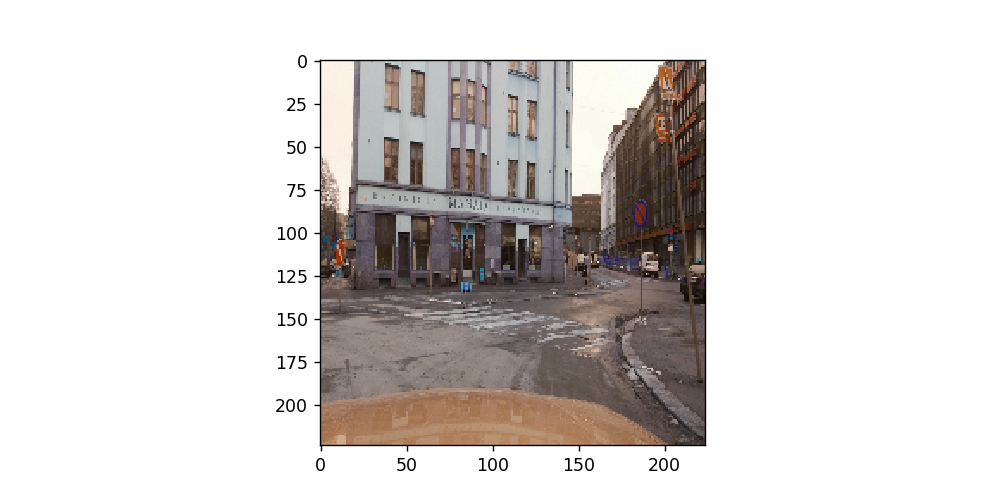

In [321]:
a, b = generator.next()

show_image(a[0,:,:][:,:,::-1].astype('uint8'))

In [7]:
import json

with open('/home/husky/data/mapillary-vistas-dataset_public_v1.0/config.json') as config:
    config = json.load(config)
    
for label in config['labels']:
    print label['color'], label['readable']

[165, 42, 42] Bird
[0, 192, 0] Ground Animal
[196, 196, 196] Curb
[190, 153, 153] Fence
[180, 165, 180] Guard Rail
[102, 102, 156] Barrier
[102, 102, 156] Wall
[128, 64, 255] Bike Lane
[140, 140, 200] Crosswalk - Plain
[170, 170, 170] Curb Cut
[250, 170, 160] Parking
[96, 96, 96] Pedestrian Area
[230, 150, 140] Rail Track
[128, 64, 128] Road
[110, 110, 110] Service Lane
[244, 35, 232] Sidewalk
[150, 100, 100] Bridge
[70, 70, 70] Building
[150, 120, 90] Tunnel
[220, 20, 60] Person
[255, 0, 0] Bicyclist
[255, 0, 0] Motorcyclist
[255, 0, 0] Other Rider
[200, 128, 128] Lane Marking - Crosswalk
[255, 255, 255] Lane Marking - General
[64, 170, 64] Mountain
[128, 64, 64] Sand
[70, 130, 180] Sky
[255, 255, 255] Snow
[152, 251, 152] Terrain
[107, 142, 35] Vegetation
[0, 170, 30] Water
[255, 255, 128] Banner
[250, 0, 30] Bench
[0, 0, 0] Bike Rack
[220, 220, 220] Billboard
[170, 170, 170] Catch Basin
[222, 40, 40] CCTV Camera
[100, 170, 30] Fire Hydrant
[40, 40, 40] Junction Box
[33, 33, 33] Mail

# Construct the network

In [8]:
"""
    Construct the encoder
"""
# 13 Conv. Layers of VGG16
inputs = Input(shape=(FRAME_H, FRAME_W, 3))

# Block 1
x = ZeroPadding2D(padding=(100, 100))(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='block1_conv1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool1')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool2')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool3')(x)

pool3 = x # skip connection

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool4')(x)

pool4 = x # skip conection

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block5_pool5')(x)

# Block 6
x = Conv2D(4096, (7, 7), activation='relu', padding='valid', name='block6_conv1')(x)
x = Dropout(0.5)(x)
x = Conv2D(4096, (1, 1), activation='relu', padding='valid', name='block6_conv2')(x)
x = Dropout(0.5)(x)

"""
    Construct the decoder
"""
# Feature 1 thread
x = Lambda(lambda xx: xx * scale_feat1, name='scale_feat1')(x)
x = Conv2D(filters=classes, kernel_size=(1, 1), name='score_feat1')(x)
y = Conv2DTranspose(filters=classes, kernel_size=(4, 4), strides=(2, 2), padding='valid', use_bias=False, name='upscore_feat1')(x)

# Feature 2 thread
pool4 = Lambda(lambda xx: xx * scale_feat2, name='scale_feat2')(pool4)
pool4 = Conv2D(filters=classes, kernel_size=(1, 1), name='score_feat2')(pool4)
pool4 = CroppingLike2D(target=y, offset='centered', name='crop_feat2')(pool4)

y = add([y, pool4]) # merge feature 1 and feature 2
y = Conv2DTranspose(filters=classes, kernel_size=(4, 4), strides=(2, 2), padding='valid', use_bias=False, name='upscore_feat2')(y)

# Feature 3 thread
pool3 = Lambda(lambda xx: xx * scale_feat3, name='scale_feat3')(pool3)
pool3 = Conv2D(filters=classes, kernel_size=(1, 1), name='score_feat3')(pool3)
pool3 = CroppingLike2D(target=y, offset='centered', name='crop_feat3')(pool3)

y = add([y, pool3]) # merge feature 3 to feature 1 and feature 2
y = Conv2DTranspose(filters=classes, kernel_size=(16, 16), strides=(8, 8), padding='valid', use_bias=False, name='upscore_feat3')(y)

# Adjust the final output to have the shape of input
outputs = CroppingLike2D(target=inputs, offset='centered', name='score')(y)

model = Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 424, 424, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 422, 422, 64)  1792        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 422, 422, 64)  36928       block1_conv1[0][0]               
___________________________________________________________________________________________

# Load pre-trained weight

In [12]:
"""from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False)

for i in xrange(len(vgg16.layers)):
    if vgg16.layers[i].trainable:
        model.layers[i+1].set_weights(vgg16.layers[i].get_weights())"""

"from keras.applications.vgg16 import VGG16\n\nvgg16 = VGG16(weights='imagenet', include_top=False)\n\nfor i in xrange(len(vgg16.layers)):\n    if vgg16.layers[i].trainable:\n        model.layers[i+1].set_weights(vgg16.layers[i].get_weights())"

# Train the neural network

In [10]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

batch_num = 4

gen_train = BatchGenerator('/home/husky/data/mapillary-vistas-dataset_public_v1.0/training/', batch_num)
gen_valid = BatchGenerator('/home/husky/data/mapillary-vistas-dataset_public_v1.0/validation/', batch_num, jitter = False)

In [11]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true[:,:,:,0], tf.int32)
    
    weight = tf.ones(tf.shape(y_true))
    weight = weight + tf.cast(tf.equal(y_true, 2), tf.float32)*7
    
    #y_true = tf.Print(y_true, [tf.reduce_sum(tf.cast(tf.equal(y_true, 2), tf.float32))], message='DEBUG', summarize=10000)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    loss = loss * weight
    loss = tf.reduce_mean(loss)
    
    return loss

In [7]:
model.load_weights('weights.hdf5')

In [15]:
tb_counter  = max([int(num) for num in os.listdir('../logs/segnet/')] or [0]) + 1
tensorboard = TensorBoard(log_dir='../logs/segnet/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

sgd = SGD(lr=0.0001, decay=0.0005, momentum=0.9)

model.compile(loss=custom_loss, optimizer=sgd)
#model.compile(loss=custom_loss, optimizer='adam')

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 30, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_q_size = 8)

Epoch 1/30
4500/4500 [==============================] - 7574s - loss: 0.4219 - val_loss: 0.3363
Epoch 2/30
4500/4500 [==============================] - 7558s - loss: 0.4073 - val_loss: 0.3377
Epoch 3/30
4500/4500 [==============================] - 7568s - loss: 0.4015 - val_loss: 0.3359
Epoch 4/30
4500/4500 [==============================] - 7559s - loss: 0.3977 - val_loss: 0.3369
Epoch 00003: early stopping


# Evaluate the network

In [13]:
generator = BatchGenerator('/home/husky/data/mapillary-vistas-dataset_public_v1.0/validation/', 1, jitter = False, norm=False).get_gen()

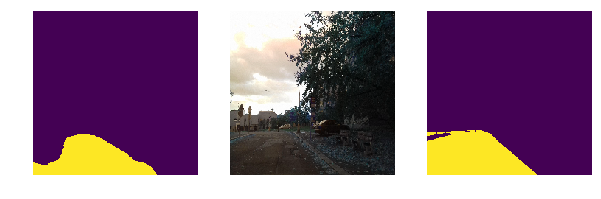

In [14]:
a, b = generator.next()
c = model.predict(a)

plt.figure(figsize=(10,30))

show_image(np.argmax(c, axis=-1)[0].astype('uint8'), ax=plt.subplot(131))
show_image(a[0].astype('uint8'), ax=plt.subplot(132))
show_image(b[0,:,:,0].astype('uint8')*255, ax=plt.subplot(133))

## Segment image

In [304]:
class Perceriver(object):
    def __init__(self):
        self.last_l_lane = None
        self.last_r_lane = None
        
    def perceive(self, image, model):
        # Get the softmax prediction of each pixel
        net_in = cv2.resize(image, (224,224))
        net_in = np.expand_dims(normalize(net_in), axis=0)
        segmen = model.predict(net_in)
        
        # Compute the edge map
        edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #edge = cv2.filter2D(edge, -1, kernel)
        edge = cv2.GaussianBlur(edge, (3, 3), 0)
        edge = cv2.Canny(edge, 10, 50)

        # Get the mask of the lane and the road
        road = self.get_mask(image, segmen, [1])
        lane = self.get_mask(image, segmen, [2])
        mask = road + lane

        if np.sum(mask) == 0: return image # return if no drivable pixel is found

        # Find the exact positions of the lanes
        l_lane = {}
        r_lane = {}

        step = 5
        top_line = np.where(np.sum(road, axis=1) > 0)[0][0]
        bot_line = np.where(np.sum(road, axis=1) > 0)[0][-1]
        top_line = int(np.ceil(top_line/step)*step) # make sure that the strips are divisible by step

        for i in xrange(top_line, bot_line, step):
            strip = np.sum(lane[i:i+step, :], axis=0)
            strip_edge = np.sum(edge[i:i+step, :], axis=0)

            # Find the clusters of the points
            #last_positions = [None, None]
            #if self.last_l_lane is not None:
            #    last_positions[0] = [self.last_l_lane.get(i)]
            #if self.last_r_lane is not None:
            #    last_positions[1] = [self.last_r_lane.get(i)]
                
            positions = self.find_lane_positions(strip, strip_edge, lane.shape[1]/2)

            l_lane[i] = positions[0]
            r_lane[i] = positions[1]

            #if l_lane[i] is not None:
            #    image = cv2.circle(image, (l_lane[i], i), 3, (255,0,0), thickness=3)
            #if r_lane[i] is not None:
            #    image = cv2.circle(image, (r_lane[i], i), 3, (0,255,255), thickness=3)

        # Clever way to ensure that the predictions are temporally consistent
        l_lane = self.kalman_filter(l_lane, self.last_l_lane, lane.shape[1])
        r_lane = self.kalman_filter(r_lane, self.last_r_lane, lane.shape[1])

        # Fit the points with a second order polynomial using RANSAC
        l_lane = self.adjust_line(l_lane)
        r_lane = self.adjust_line(r_lane)

        # Overlay the masks and fitted lanes on the image
        image = self.overlay(image, lane, color=(143,124,0))
        image = self.overlay(image, road, color=(10, 196, 196))

        if len(l_lane) > 0: image = cv2.polylines(image, [l_lane], False, (0,0,255), thickness=5)
        if len(r_lane) > 0: image = cv2.polylines(image, [r_lane], False, (0,0,255), thickness=5)

        # Save the last lane for kalman filering 
        self.last_l_lane = {}
        for point in l_lane:
            self.last_l_lane[point[1]] = point[0]

        self.last_r_lane = {}
        for point in r_lane:
            self.last_r_lane[point[1]] = point[0]

        return image
    
    def kalman_filter(self, lane, last_lane, image_width):
        old_lane = lane.copy()
        counter = 0
        counter_all = 0
        
        if last_lane is not None:
            for strip in lane.keys():
                if strip in last_lane:
                    if (lane[strip] == None):
                        lane[strip] = last_lane[strip]
                    else:
                        if np.abs(lane[strip] - last_lane[strip]) > image_width/20:
                            lane[strip] = last_lane[strip] * 0.9 + lane[strip] * 0.1
                            counter += 1
                        else:
                            lane[strip] = last_lane[strip] * 0.1 + lane[strip] * 0.9
                            
                        counter_all += 1
        
        # lane change detected, past lane is discarded
        if counter > 10 and counter > counter_all * 0.8:
            old_lane = np.array([[old_lane[point], point] for point in sorted(old_lane.keys())])
            return old_lane
        else:
            lane = np.array([[lane[point], point] for point in sorted(lane.keys())])
            return lane
        """if last_lane is not None:
            for strip in lane.keys():
                if strip in last_lane:
                    if lane[strip] == None:
                        lane[strip] = last_lane[strip]
                    else:
                        difference = np.abs(lane[strip] - last_lane[strip])
                        alpha = np.exp(-difference/50)
                        lane[strip] = last_lane[strip]*(1-alpha) + lane[strip]*alpha
                        #print last_lane[strip], lane[strip]

        lane = np.array([[lane[point], point] for point in sorted(lane.keys())])

        return lane"""

    def find_lane_positions(self, strip, strip_edge, middle_line):
        thresh = 10.0
        indices = np.where(strip > 0)[0]
        edges = np.where(strip_edge > 0)[0]

        if len(indices) > 1:
            indices = indices.reshape(-1,1)
            clusters = hcluster.fclusterdata(indices, thresh, criterion="distance")

            positions = {}
            for i in set(clusters):
                cluster = indices[clusters==i]
                l_bound = np.min(cluster)
                r_bound = np.max(cluster)
                cluster_edges = np.sort(edges[np.where((l_bound <= edges) & (edges <=r_bound))])

                if len(cluster_edges) > 1:
                    weights = np.arange(len(cluster_edges))
                    l_proposal = int(np.average(cluster_edges, weights = weights))
                    r_proposal = int(np.average(cluster_edges, weights = np.flip(weights, axis=0)))
                    
                    positions[int(np.mean(cluster))] = [r_proposal, l_proposal] #int(np.mean(cluster_edges))
                else:
                    positions[int(np.mean(cluster))] = -1
                    
            keys = np.array(sorted(positions.keys()))
            
            l_can = keys[keys <  middle_line]
            r_can = keys[keys >= middle_line]
            
            l_point = None
            r_point = None

            if len(l_can) > 0 and positions[l_can[-1]] != -1:
                l_point = positions[l_can[-1]][1]  
                
            if len(r_can) > 0 and positions[r_can[0]]  != -1:
                r_point = positions[r_can[0]][0]  
                
            return [l_point, r_point]
        else:
            return [None, None]
    
    def get_mask(self, image, segmen, mask_ids):
        mask = np.zeros(segmen.shape[1:3])

        segmen = np.argmax(segmen, axis=-1)[0]

        for mask_id in mask_ids:
            mask += (segmen == mask_id).astype('uint8')

        mask = np.ceil(resize(mask, image.shape[:2], mode='constant', preserve_range=True)).astype('uint8')

        return mask
    
    def adjust_line(self, line):
        regressor = RANSACRegressor()

        if len(line) > 0:
            indices = line[:,0] != None
            
            # prepare data to fit a second order model using RANSAC
            coor = line[indices,1].reshape(-1,1).astype(np.float)

            inp_columns = np.concatenate([np.ones_like(coor), coor, coor**1], axis=1)
            out_columns = line[indices, 0]

            # try RANSAC for at least 3 times before giving up
            for _ in xrange(3):
                try:
                    regressor.fit(inp_columns, out_columns)

                    coor = line[:,1].reshape(-1,1).astype(np.float)
                    inp_columns = np.concatenate([np.ones_like(coor), coor, coor**1], axis=1)
                    
                    line[:,0] = regressor.predict(inp_columns)
                    line = line.astype('int')

                    break
                except:
                    pass
        return line

    def overlay(self, image, mask, color = (128, 64, 255), alpha = 0.2):
        mask  = mask[..., np.newaxis] * np.array(color)[np.newaxis, np.newaxis, ...]
        image = image * (1-alpha) + mask * alpha

        return image.astype('uint8')

<IPython.core.display.Javascript object>


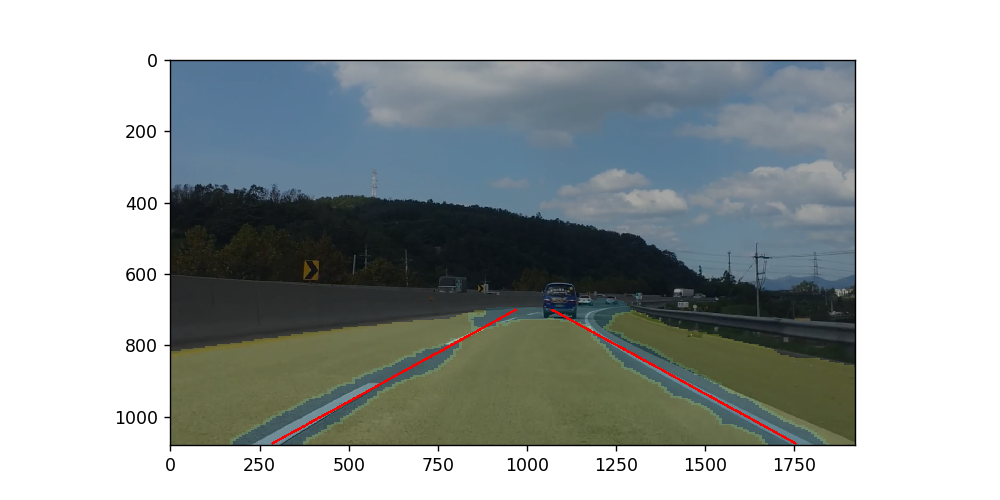

In [303]:
perceiver = Perceriver()

image = cv2.imread('road_13.png')
image = perceiver.perceive(image, model)

show_image(image)

## Experiment

<IPython.core.display.Javascript object>


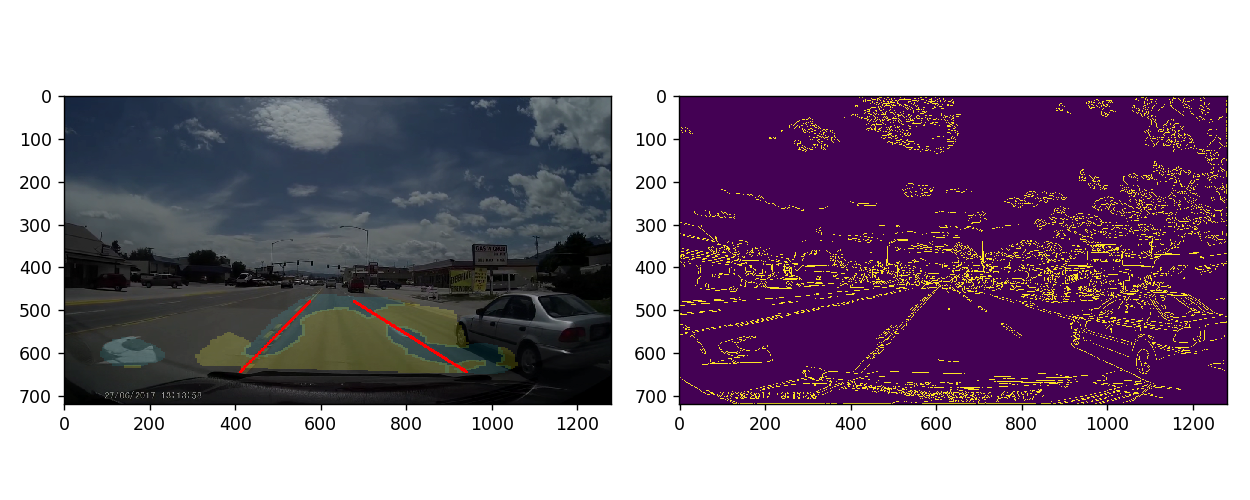

In [319]:
video_inp = 'montana_short' + '.mp4'

video_reader = cv2.VideoCapture(video_inp)
video_writer = None

ret, image = video_reader.read()
perceiver = Perceriver()

fig = plt.figure(figsize=(10,4))
plt.subplot(121); image_plot = plt.imshow(image)
plt.subplot(122); bprop_plot = plt.imshow(image[:,:,0])

counter = 0

def updatefig(*args):
    global counter
    
    ret, image = video_reader.read()
    
    if ret and counter > -1:
        edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edge = cv2.GaussianBlur(edge, (3, 3), 0)
        edge = cv2.Canny(edge, 10, 50)
        bprop_plot.set_array(edge)
        
        image = perceiver.perceive(image, model)
        image_plot.set_array(image[:,:,::-1])
        
    counter += 1

plt.tight_layout()
ani = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, save_count=20000) 
plt.show()

## Segment video

In [320]:
video_inp = 'montana_short' + '.mp4'
video_out = 'montana_short' + '_lane.mp4'

video_reader = cv2.VideoCapture(video_inp)
video_writer = None

perceiver = Perceriver()
    
while(True):
    ret, frame = video_reader.read()

    if ret == True:
        frame = perceiver.perceive(frame, model)
        
        if video_writer is None:
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            video_writer = cv2.VideoWriter(video_out, fourcc, 25.0, (frame.shape[1], frame.shape[0]))
            
        video_writer.write(np.uint8(frame))
    else:
        break

video_reader.release()
video_writer.release()